<a href="https://colab.research.google.com/github/analyticsforliving/bank_transaction_recoveries_rege_ucc4a_risk_scoring_generativeai_genai/blob/main/Loan_Risk_Demo_Synthetic_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# SMB Loan Risk Demo (Synthetic, Governance-Ready) — Reviews + Bank Statements + Credit + Application

This Colab notebook generates **synthetic** datasets (no third‑party or PII content), engineers features over **24 months**, trains an **XGBoost** classifier for **low/medium/high** risk bands, emits **reason codes** for adverse-action narratives, provides **underwriter summaries**, an optional **GenAI chat**, and a **fair‑lending governance** section with illustrative checks.

> ⚖️ **Governance**: For production at a bank/fintech, align to **ECOA/Reg B**, **UDAAP**, **SR 11‑7** (model risk), and **CFPB 1071** program requirements. This notebook is for demonstration and portfolio use only.


## Evaluate and discuss results

Now we will analyze the model performance metrics, feature importance, and SHAP values from the latest model training run. We will discuss how the increased variability in the synthetic data affects the model's ability to predict risk and the insights gained from the different metrics and explanations.

## Risk Bands

The synthetic risk score is categorized into three risk bands:

*   **Low Risk**: Businesses with a synthetic risk score between 0.00 and 0.33.
*   **Medium Risk**: Businesses with a synthetic risk score between 0.34 and 0.66.
*   **High Risk**: Businesses with a synthetic risk score between 0.67 and 1.00.

These risk bands are used as the target variable for the model.

In [56]:

%%bash
pip -q install xgboost==2.1.1 gradio==4.44.0 google-generativeai==0.7.2


In [57]:
%%bash
pip uninstall -y shap scikit-learn
pip install -q scikit-learn==1.6.1 shap xgboost==2.1.1 gradio==4.44.0 google-generativeai==0.7.2 matplotlib seaborn

Found existing installation: shap 0.48.0
Uninstalling shap-0.48.0:
  Successfully uninstalled shap-0.48.0
Found existing installation: scikit-learn 1.7.2
Uninstalling scikit-learn-1.7.2:
  Successfully uninstalled scikit-learn-1.7.2


In [58]:
%%bash
pip -q install -U scikit-learn matplotlib seaborn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.


In [59]:
import os, json, math, datetime as dt, numpy as np, pandas as pd
from pathlib import Path
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# Optional LLM (Gemini) for chat
try:
    import google.generativeai as genai
except Exception:
    genai = None

import gradio as gr

RNG = np.random.default_rng(17)
pd.options.display.float_format = lambda x: f"{x:,.4f}"

0) Drive path config (matches your real folders)

In [60]:
# === Drive path config (single source of truth) ===
from pathlib import Path
import os, time, shutil

# Mount Drive (safe if already mounted)
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Base and concrete subfolders (match your structure exactly)
BASE_DRIVE = "/content/drive/Shareddrives/1c_loan_risk_scoring"

DRIVE_DIR_MODEL     = f"{BASE_DRIVE}/model"
DRIVE_DIR_MONITOR   = f"{BASE_DRIVE}/monitoring"
DRIVE_DIR_DATA      = f"{BASE_DRIVE}/loan_demo_data"
DRIVE_FL_DIR        = f"{BASE_DRIVE}/fair_lending_governance"
DRIVE_DIR_SUMMARIES = f"{BASE_DRIVE}/underwriter_summaries (1)"
DRIVE_DIR_EXPORTS   = f"{BASE_DRIVE}/exports"

# Toggle: also push feature/data snapshots to DRIVE_DIR_DATA
SAVE_DATASETS_TO_DRIVE = True

# Ensure folders exist
for d in [DRIVE_DIR_MODEL, DRIVE_DIR_MONITOR, DRIVE_DIR_DATA, DRIVE_FL_DIR, DRIVE_DIR_SUMMARIES, DRIVE_DIR_EXPORTS]:
    os.makedirs(d, exist_ok=True)

# Reusable helper (make globally available)
def copy_with_ts(src: Path, dst_dir: str):
    """Copy src to dst_dir with a timestamp prefix; print the final path."""
    src = Path(src)
    if not src.exists():
        print(f"⚠️  Missing (skip): {src}")
        return None
    ts = time.strftime("%Y%m%d_%H%M%S")
    dst = Path(dst_dir) / f"{ts}_{src.name}"
    shutil.copy2(src, dst)
    print(f"✅ Saved to Drive: {dst}")
    return dst

print("Paths set:")
print(" MODEL     →", DRIVE_DIR_MODEL)
print(" MONITOR   →", DRIVE_DIR_MONITOR)
print(" DATA      →", DRIVE_DIR_DATA)
print(" GOVERN    →", DRIVE_FL_DIR)
print(" SUMMARIES →", DRIVE_DIR_SUMMARIES)
print(" EXPORTS   →", DRIVE_DIR_EXPORTS)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Paths set:
 MODEL     → /content/drive/Shareddrives/1c_loan_risk_scoring/model
 MONITOR   → /content/drive/Shareddrives/1c_loan_risk_scoring/monitoring
 DATA      → /content/drive/Shareddrives/1c_loan_risk_scoring/loan_demo_data
 GOVERN    → /content/drive/Shareddrives/1c_loan_risk_scoring/fair_lending_governance
 SUMMARIES → /content/drive/Shareddrives/1c_loan_risk_scoring/underwriter_summaries (1)
 EXPORTS   → /content/drive/Shareddrives/1c_loan_risk_scoring/exports


## Increase sample size (optional)

To increase the sample size of businesses in the synthetic data, modify the `make_businesses` function call in the cell below and change the value of the `n` parameter. For example, to generate 500 businesses, change `make_businesses(60)` to `make_businesses(n=500)`. After changing the number, you will need to re-run this cell and all subsequent cells to regenerate the data and retrain the model with the larger sample size.

## 1) Synthetic data generators (businesses, reviews, **24m bank statements**, applications)

In [61]:
def bounded_walk(n, start, step=0.12, lo=2.2, hi=4.9, shock_p=0.08):
    x = start
    out = []
    for _ in range(n):
        if RNG.random() < shock_p:
            x += RNG.normal(0, 0.6)
        x += RNG.normal(0, step)
        x = min(hi, max(lo, x))
        out.append(x)
    return np.array(out)

def make_businesses(n: int = 60) -> pd.DataFrame:
    cities = [('New York','NY'), ('Miami','FL'), ('Dallas','TX'), ('Los Angeles','CA'), ('Chicago','IL'), ('Phoenix','AZ'), ('Atlanta','GA')]
    cats = ['Restaurant;Mexican','Restaurant;Pizza','Retail;Grocery','Service;Auto','Health;Dental','Coffee;Cafe','Restaurant;Seafood']
    start_date = dt.date(2019,1,1)

    rows = []
    for i in range(n):
        city, state = cities[i % len(cities)]
        open_offset = int(RNG.integers(0, 365*4))
        open_date = start_date + dt.timedelta(days=open_offset)
        tenure_months = max(1, int((dt.date(2025,8,31) - open_date).days // 30))
        rows.append({
            "business_id": f"m{i:03d}",
            "name": f"Merchant {chr(65+(i%26))}{'' if i<26 else str(i//26)}",
            "categories": cats[i % len(cats)],
            "city": city, "state": state,
            "open_date": str(open_date),
            "is_franchise": int(RNG.choice([0,1], p=[0.75,0.25])),
            "employee_band": RNG.choice(['1-4','5-19','20-49','50+'], p=[0.4,0.4,0.15,0.05]),
            "tenure_months": int(tenure_months),
            "license_active": int(RNG.choice([1,0], p=[0.95,0.05])),
            "inspection_score": int(np.clip(RNG.normal(88, 6), 60, 100)),
            "seasonality_index": float(np.round(np.clip(RNG.normal(1.0, 0.18), 0.6, 1.6), 2))
        })
    return pd.DataFrame(rows)

def make_reviews(business: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    months = pd.period_range('2022-01', '2025-08', freq='M')
    monthly_rows = []
    for b in business.itertuples():
        base_rate = RNG.uniform(4, 45) * (1.2 if b.is_franchise else 1.0) * b.seasonality_index
        rates = np.clip(RNG.normal(base_rate, base_rate*0.28, len(months)), 0.5, None)
        avg_stars = bounded_walk(len(months), start=RNG.uniform(3.0,4.6))
        for m, lam, mu in zip(months, rates, avg_stars):
            monthly_rows.append({
                "business_id": b.business_id,
                "month_year": m.strftime("%Y-%m"),
                "review_count": int(RNG.poisson(lam)),
                "avg_stars_month": float(mu)
            })
    monthly = pd.DataFrame(monthly_rows)

    review_rows = []
    user_registry = {}
    for row in monthly.itertuples():
        n = int(row.review_count)
        if n <= 0: continue
        indiv = np.clip(RNG.normal(row.avg_stars_month, 0.7, n), 1.0, 5.0)
        stars = np.rint(indiv * 2) / 2
        base_date = dt.datetime.strptime(row.month_year, "%Y-%m")
        for s in stars:
            d = (base_date + pd.offsets.MonthEnd(0)).to_pydatetime().date()
            d = d - dt.timedelta(days=int(RNG.integers(0,27)))
            uid = f"u{RNG.integers(1, 90000):06d}"
            user_registry.setdefault(uid, {
                "user_id": uid,
                "yelper_since": str(d - dt.timedelta(days=int(RNG.integers(365, 365*10))))
            })
            review_rows.append({
                "review_id": f"r{len(review_rows)+1:09d}",
                "user_id": uid, "business_id": row.business_id,
                "stars": float(s), "date": str(d),
                "text": RNG.choice([
                    "Great service and clean place.",
                    "Long wait but food was good.",
                    "Fair prices and friendly staff.",
                    "Inconsistent quality lately.",
                    "Excellent experience, will return.",
                    "Could improve on speed."
                ]),
                "useful": int(np.clip(RNG.poisson(0.2), 0, 10)),
                "funny": int(np.clip(RNG.poisson(0.05), 0, 5)),
                "cool"  : int(np.clip(RNG.poisson(0.1), 0, 10)),
            })
    reviews = pd.DataFrame(review_rows)
    users = pd.DataFrame(user_registry.values())
    return reviews, users

def make_bank_statements(business: pd.DataFrame, months_back: int = 24) -> pd.DataFrame:
    # Generate 24 months of monthly deposits/outflows/end_balance with seasonality and trend
    end_month = pd.Period('2025-08', freq='M')
    periods = [end_month - i for i in range(months_back-1, -1, -1)]
    rows = []
    for b in business.itertuples():
        level = RNG.uniform(12000, 180000) * (1.25 if b.is_franchise else 1.0)
        trend = RNG.normal(0, level*0.002)   # monthly drift
        seasonal_amp = RNG.uniform(0.05, 0.35) * b.seasonality_index
        balance = RNG.uniform(1000, level*0.3)
        debt_pmt = RNG.uniform(0, 6000)  # existing periodic debt service

        for t, p in enumerate(periods):
            # seasonality: simple sinusoid by month number
            month_idx = (t % 12)
            season = 1.0 + seasonal_amp * math.sin(2*math.pi*month_idx/12.0)
            deposits = max(1000, RNG.normal(level*season + trend*t, level*0.18))
            outflows = max(800, RNG.normal(deposits*RNG.uniform(0.75, 1.05), deposits*0.15))
            nsf = int(np.clip(RNG.poisson( (outflows - deposits > 2000) * RNG.uniform(0.2, 0.8) ), 0, 6))
            chargebacks = int(np.clip(RNG.poisson( RNG.uniform(0.0, 0.4) ), 0, 5))
            returns = int(np.clip(RNG.poisson( RNG.uniform(0.0, 0.5) ), 0, 6))
            balance = max(0, balance + deposits - outflows)
            rows.append({
                "business_id": b.business_id,
                "month": p.to_timestamp('M'),
                "total_deposits": float(deposits),
                "total_outflows": float(outflows),
                "end_balance": float(balance),
                "debt_service_existing": float(debt_pmt),
                "nsf_count": nsf,
                "chargeback_count": chargebacks,
                "returned_ach_count": returns
            })
    return pd.DataFrame(rows)

def make_applications(business: pd.DataFrame) -> pd.DataFrame:
    today = dt.date(2025,9,1)
    products = ["term_loan","loc"]
    purposes = ["working_capital","equipment","expansion","refinance"]
    rows = []
    for b in business.itertuples():
        product = RNG.choice(products, p=[0.65,0.35])
        term = int(RNG.integers(12, 60)) if product=="term_loan" else int(RNG.integers(6, 36))
        amount = float(np.round(RNG.uniform(25000, 350000),2))
        rate = float(np.round(RNG.uniform(0.07, 0.24),3))
        rows.append({
            "application_id": f"a{b.business_id}",
            "business_id": b.business_id,
            "application_date": str(today - dt.timedelta(days=int(RNG.integers(0,90)))),
            "product_type": product,
            "term_months": term,
            "loan_amount_requested": amount,
            "requested_rate": rate,
            "purpose": RNG.choice(purposes),
            "collateral_type": RNG.choice(["none","equipment","receivables","vehicle"], p=[0.5,0.25,0.2,0.05]),
            "collateral_value_est": float(np.round(amount*RNG.uniform(0.0, 1.2),2)),
            "entity_type": RNG.choice(["LLC","S-Corp","C-Corp","Sole Prop"], p=[0.45,0.3,0.2,0.05]),
            "years_in_business": int(max(1, b.tenure_months//12)),
            "naics_code": RNG.choice(["722511","445110","811111","621210","722513","722515"]),  # demo
            "state": b.state, "county": RNG.choice(["A","B","C","D","E"])  # simple geography bucket
        })
    return pd.DataFrame(rows)

# Generate all bases
business = make_businesses(500)
reviews, users = make_reviews(business)
statements = make_bank_statements(business, months_back=24)
applications = make_applications(business)

display(business.head())
display(reviews.head())
display(statements.head())
display(applications.head())

,business_id,name,categories,city,state,open_date,is_franchise,employee_band,tenure_months,license_active,inspection_score,seasonality_index
0,m000,Merchant A,Restaurant;Mexican,New York,NY,2021-12-17,0,5-19,45,1,76,1.0000
1,m001,Merchant B,Restaurant;Pizza,Miami,FL,2022-05-18,0,5-19,40,1,87,0.6000
2,m002,Merchant C,Retail;Grocery,Dallas,TX,2019-08-17,1,20-49,73,1,85,1.2400
3,m003,Merchant D,Service;Auto,Los Angeles,CA,2019-05-03,0,1-4,77,1,94,1.1900
4,m004,Merchant E,Health;Dental,Chicago,IL,2019-07-26,1,20-49,74,1,74,1.3600


,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,r000000001,u082778,m000,4.5000,2022-01-18,Fair prices and friendly staff.,0,0,0
1,r000000002,u049468,m000,4.5000,2022-01-21,Great service and clean place.,0,0,0
2,r000000003,u089018,m000,3.0000,2022-01-19,Inconsistent quality lately.,0,0,0
3,r000000004,u042955,m000,3.0000,2022-01-21,Long wait but food was good.,0,0,0
4,r000000005,u031703,m000,4.0000,2022-01-13,Inconsistent quality lately.,1,0,0


,business_id,month,total_deposits,total_outflows,end_balance,debt_service_existing,nsf_count,chargeback_count,returned_ach_count
0,m000,2023-09-30,"165,472.6124","146,682.2576","40,060.7226","5,585.9815",0,0,1
1,m000,2023-10-31,"223,706.3701","215,452.7760","48,314.3167","5,585.9815",0,0,0
2,m000,2023-11-30,"132,368.5772","116,390.2180","64,292.6759","5,585.9815",0,0,0
3,m000,2023-12-31,"218,506.9562","163,265.1268","119,534.5052","5,585.9815",0,0,0
4,m000,2024-01-31,"260,746.5340","289,492.1564","90,788.8827","5,585.9815",0,0,0


,application_id,business_id,application_date,product_type,term_months,loan_amount_requested,requested_rate,purpose,collateral_type,collateral_value_est,entity_type,years_in_business,naics_code,state,county
0,am000,m000,2025-08-30,term_loan,45,"331,491.9300",0.1400,expansion,equipment,"98,679.7500",LLC,3,722515,NY,A
1,am001,m001,2025-06-09,term_loan,26,"277,984.1100",0.2240,refinance,none,"117,337.6200",S-Corp,3,722513,FL,A
2,am002,m002,2025-07-25,loc,23,"192,190.8700",0.2040,expansion,none,"204,304.3300",LLC,6,722513,TX,C
3,am003,m003,2025-07-04,loc,18,"208,912.7700",0.1830,expansion,receivables,"133,436.9700",C-Corp,6,722511,CA,D
4,am004,m004,2025-07-22,loc,29,"283,795.9200",0.1230,expansion,none,"178,174.7300",S-Corp,6,722513,IL,B


## 2) Feature engineering (reviews 12m; bank statements 3/6/12/24m; trend & seasonality; join application)

In [62]:

# Review features
r = reviews.copy()
r["date"] = pd.to_datetime(r["date"])
r["month"] = r["date"].dt.to_period("M").dt.to_timestamp("M")
monthly_rev = r.groupby(["business_id","month"]).agg(
    n_reviews=("stars","size"),
    avg_stars=("stars","mean"),
    p_1star=("stars", lambda s: float((s<=1.5).mean())),
    p_5star=("stars", lambda s: float((s>=4.5).mean()))
).reset_index()
monthly_rev["roll12_n"]   = monthly_rev.groupby("business_id")["n_reviews"].transform(lambda s: s.rolling(12, min_periods=1).sum())
monthly_rev["roll12_avg"] = monthly_rev.groupby("business_id")["avg_stars"].transform(lambda s: s.rolling(12, min_periods=3).mean())
monthly_rev["roll12_vol"] = monthly_rev.groupby("business_id")["avg_stars"].transform(lambda s: s.rolling(12, min_periods=3).std())

# Bank statement window features
s = statements.copy()
s = s.sort_values(["business_id","month"])
def window_feats(df: pd.DataFrame, win: int, prefix: str) -> pd.DataFrame:
    g = df.groupby("business_id")
    out = df[["business_id","month"]].copy()
    out[f"{prefix}_dep_mean"] = g["total_deposits"].transform(lambda x: x.rolling(win, min_periods=win//2).mean())
    out[f"{prefix}_out_mean"] = g["total_outflows"].transform(lambda x: x.rolling(win, min_periods=win//2).mean())
    out[f"{prefix}_dep_cv"]   = g["total_deposits"].transform(lambda x: (x.rolling(win, min_periods=win//2).std() / (x.rolling(win, min_periods=win//2).mean()+1e-6)))
    out[f"{prefix}_nsf_rate"] = g["nsf_count"].transform(lambda x: x.rolling(win, min_periods=win//2).mean())
    out[f"{prefix}_ret_rate"] = g["returned_ach_count"].transform(lambda x: x.rolling(win, min_periods=win//2).mean())
    out[f"{prefix}_cb_rate"]  = g["chargeback_count"].transform(lambda x: x.rolling(win, min_periods=win//2).mean())
    out[f"{prefix}_buffer_days"] = g["end_balance"].transform(lambda x: (x.rolling(win, min_periods=win//2).mean() / (df["total_outflows"].rolling(win, min_periods=win//2).mean()+1e-6) * 30.0))
    return out

w3  = window_feats(s, 3,  "w3")
w6  = window_feats(s, 6,  "w6")
w12 = window_feats(s, 12, "w12")
w24 = window_feats(s, 24, "w24")

# Trend via simple linear slope on deposits (12m, 24m)
def slope_over_window(x, win):
    if len(x) < 2: return np.nan
    y = x[-win:]
    t = np.arange(len(y))
    denom = (t**2).sum() - t.sum()**2/len(t)
    if denom == 0: return 0.0
    slope = ((t*y).sum() - t.sum()*y.sum()/len(t)) / denom
    return slope

dep_slope_12 = s.groupby("business_id")["total_deposits"].apply(lambda x: slope_over_window(x.values, min(12, len(x)))).reset_index(name="dep_slope_12")
dep_slope_24 = s.groupby("business_id")["total_deposits"].apply(lambda x: slope_over_window(x.values, min(24, len(x)))).reset_index(name="dep_slope_24")

# Seasonality index: month over 12m moving average for last 12 months
s2 = s.copy()
s2["dep_ma12"] = s2.groupby("business_id")["total_deposits"].transform(lambda x: x.rolling(12, min_periods=6).mean())
s2["seasonality_index"] = s2["total_deposits"] / (s2["dep_ma12"] + 1e-6)

# Latest snapshots (align months across tables)
rev_snap = monthly_rev.sort_values(["business_id","month"]).groupby("business_id").tail(1)
stmt_snap = s.sort_values(["business_id","month"]).groupby("business_id").tail(1)
season_snap = s2.sort_values(["business_id","month"]).groupby("business_id").tail(1)

# Join features
feat = rev_snap.merge(stmt_snap[["business_id","total_deposits","total_outflows","end_balance"]], on="business_id", how="left")
for w in (w3,w6,w12,w24):
    feat = feat.merge(w, on=["business_id","month"], how="left")
feat = feat.merge(season_snap[["business_id","seasonality_index"]], on="business_id", how="left")
feat = feat.merge(dep_slope_12, on="business_id", how="left")
feat = feat.merge(dep_slope_24, on="business_id", how="left")
feat = feat.merge(business[["business_id","is_franchise","employee_band","license_active","inspection_score","tenure_months","state","city"]], on="business_id", how="left")
feat = feat.merge(applications, on="business_id", how="left")

# Financial calcs
# Income (proxy) = deposits; Expenses (proxy) = outflows; NOI ≈ deposits - outflows
feat["noi_proxy"] = (feat["total_deposits"] - feat["total_outflows"]).clip(lower=0)
# Estimated debt service = existing + requested (term payment approx. using simple amortization)
def term_payment(principal, annual_rate, months):
    if months <= 0: return 0.0
    r = annual_rate/12.0
    if r == 0: return principal/months
    return principal * (r*(1+r)**months) / ((1+r)**months - 1)

feat["req_payment_est"] = feat.apply(lambda r: term_payment(
    r["loan_amount_requested"] if r["product_type"]=="term_loan" else r["loan_amount_requested"]*0.35,  # LOC utilization guess
    r["requested_rate"],
    r["term_months"]), axis=1)

feat["debt_service_total"] = feat["req_payment_est"] + feat["w12_dep_mean"].fillna(0)*0.0  # (existing periodic in statements already included above as cash outflow)
# DSCR (demo)
feat["dscr_demo"] = (feat["noi_proxy"]*12.0) / (feat["req_payment_est"]*12.0 + 1e-6)
# Leverage proxy
feat["leverage_demo"] = feat["loan_amount_requested"] / (feat["w12_dep_mean"]*12.0 + 1e-6)
# Cash buffer days (12m window)
feat["buffer_days_12m"] = feat["w12_buffer_days"]
# Seasonality amplitude (last 12m ratio of 95th to 5th percentile on seasonality_index)
def season_amp(bid):
    x = s2.loc[s2["business_id"]==bid, "seasonality_index"].dropna().values[-12:]
    if len(x) < 6: return np.nan
    lo, hi = np.percentile(x, 5), np.percentile(x,95)
    return hi/(lo+1e-6)
feat["seasonality_amp_12m"] = feat["business_id"].apply(season_amp)

feat.head()


,business_id,month,n_reviews,avg_stars,p_1star,p_5star,roll12_n,roll12_avg,roll12_vol,total_deposits,...,naics_code,state_y,county,noi_proxy,req_payment_est,debt_service_total,dscr_demo,leverage_demo,buffer_days_12m,seasonality_amp_12m
0,m000,2025-08-31,12,3.7500,0.0000,0.1667,137.0000,2.8495,0.5529,"124,902.9355",...,722515,NY,A,0.0000,"9,510.5391","9,510.5391",0.0000,0.1570,48.3194,4.1670
1,m001,2025-08-31,13,4.2308,0.0000,0.3846,122.0000,4.0953,0.2896,"187,945.7026",...,722513,FL,A,0.0000,"13,592.8325","13,592.8325",0.0000,0.1482,84.3986,1.4797
2,m002,2025-08-31,51,4.4118,0.0000,0.6275,470.0000,3.9814,0.2892,"142,760.8449",...,722513,TX,C,"19,075.4400","3,558.0559","3,558.0559",5.3612,0.1008,65.2241,2.0658
3,m003,2025-08-31,14,2.4643,0.2143,0.0000,203.0000,2.2288,0.2380,"66,344.7968",...,722511,CA,D,"23,649.7317","4,675.9083","4,675.9083",5.0578,0.2689,62.5734,1.9886
4,m004,2025-08-31,71,4.2183,0.0000,0.5211,887.0000,4.3809,0.0861,"112,745.0362",...,722513,IL,B,0.0000,"3,976.7608","3,976.7608",0.0000,0.2040,43.3449,1.7921


## 3) Synthetic risk label & expanded reason codes (including DSCR/seasonality/buffer/leverage)

In [63]:
# Construct continuous risk score incorporating new features
risk_raw = (
    (5 - feat["roll12_avg"]) * 12.0
    + (feat["roll12_vol"].fillna(0)*18.0)
    + (0.15 - feat["p_1star"]).clip(lower=-0.05) * -55.0
    + (feat["w12_dep_cv"].fillna(0)*40.0)
    + (feat["w12_nsf_rate"].fillna(0)*30.0)
    + (1.2 - feat["dscr_demo"].clip(upper=2.5)).apply(lambda x: max(0,x)) * 60.0
    + (feat["leverage_demo"].fillna(0)*50.0)
    + ( (feat["buffer_days_12m"].fillna(0) < 15).astype(int) * 25.0 )
    + ( (feat["seasonality_amp_12m"].fillna(1.0) > 1.6).astype(int) * 15.0 )
    + (80 - feat["inspection_score"])*1.1
    + (1 - feat["license_active"])*50.0
)
# Further increase standard deviation of random noise significantly
risk_raw = risk_raw + RNG.normal(0, 1.0, len(risk_raw))

# Normalize 0..1
risk_raw = (risk_raw - np.nanmin(risk_raw)) / (np.nanmax(risk_raw) - np.nanmin(risk_raw) + 1e-8)
feat["risk_score_synth"] = np.round(risk_raw, 3)
feat["risk_band"] = pd.cut(feat["risk_score_synth"], bins=[-0.01, 0.33, 0.66, 1.0], labels=["low","medium","high"])

REASON_CODES = {
    "LOW_REVIEW_COVERAGE": "Insufficient review coverage in the last 12 months",
    "LOW_AVG_RATING": "Low 12-month average rating",
    "HIGH_RATING_VOLATILITY": "High volatility in recent ratings",
    "HIGH_DEP_VARIABILITY": "Unstable cash-flow (high deposit variability)",
    "HIGH_NSF_RATE": "Frequent NSF/returns in recent months",
    "LOW_DSCR": "Debt service coverage ratio is below threshold",
    "HIGH_LEVERAGE": "Requested amount is high versus revenues",
    "THIN_BUFFER": "Thin cash buffer (low balance relative to outflows)",
    "HIGH_SEASONALITY": "High exposure to seasonality in revenues",
    "LICENSE_INACTIVE": "Business license appears inactive",
    "LOW_INSPECTION": "Low recent inspection score"
}

def assign_reasons(row):
    reasons = []
    # Keep probabilistic assignment for reason codes and adjust thresholds and probabilities
    if row.get("roll12_n", 0) < 50 and RNG.random() < (1 - row.get("roll12_n", 0)/50)*RNG.uniform(0.8, 1.2): reasons.append("LOW_REVIEW_COVERAGE")
    if row.get("roll12_avg", 5) < 3.8 and RNG.random() < (1 - row.get("roll12_avg", 5)/3.8)*RNG.uniform(0.8, 1.2): reasons.append("LOW_AVG_RATING")
    if not pd.isna(row.get("roll12_vol")) and row.get("roll12_vol") > 0.3 and RNG.random() < (row.get("roll12_vol", 0)/0.3 - 1)*RNG.uniform(0.8, 1.2): reasons.append("HIGH_RATING_VOLATILITY")
    if row.get("w12_dep_cv", 0) > 0.2 and RNG.random() < (row.get("w12_dep_cv", 0)/0.2 - 1)*RNG.uniform(0.8, 1.2): reasons.append("HIGH_DEP_VARIABILITY")
    if row.get("w12_nsf_rate", 0) > 0.5 and RNG.random() < (row.get("w12_nsf_rate", 0))*RNG.uniform(0.8, 1.2): reasons.append("HIGH_NSF_RATE")
    if row.get("dscr_demo", 99) < 1.8 and RNG.random() < (1.8 - row.get("dscr_demo", 99)/1.8)*RNG.uniform(0.8, 1.2): reasons.append("LOW_DSCR")
    if row.get("leverage_demo", 0) > 0.3 and RNG.random() < (row.get("leverage_demo", 0)/0.3 - 1)*RNG.uniform(0.8, 1.2): reasons.append("HIGH_LEVERAGE")
    if (row.get("buffer_days_12m") is not None) and row.get("buffer_days_12m") < 25 and RNG.random() < (25 - row.get("buffer_days_12m", 25))/25*RNG.uniform(0.8, 1.2): reasons.append("THIN_BUFFER")
    if (row.get("seasonality_amp_12m") is not None) and row.get("seasonality_amp_12m") > 1.4 and RNG.random() < (row.get("seasonality_amp_12m", 1.4)/1.4 - 1)*RNG.uniform(0.8, 1.2): reasons.append("HIGH_SEASONALITY")
    if row.get("license_active", 1) == 0: reasons.append("LICENSE_INACTIVE")
    if row.get("inspection_score", 100) < 85 and RNG.random() < (85 - row.get("inspection_score", 100))/85*RNG.uniform(0.8, 1.2): reasons.append("LOW_INSPECTION")


    return reasons[:3]

feat["reason_codes"] = feat.apply(assign_reasons, axis=1)
feat[["business_id","risk_band","risk_score_synth","reason_codes"]].head(10)

,business_id,risk_band,risk_score_synth,reason_codes
0,m000,high,0.7250,"[HIGH_RATING_VOLATILITY, HIGH_DEP_VARIABILITY,..."
1,m001,medium,0.4390,[LOW_DSCR]
2,m002,low,0.1770,"[HIGH_DEP_VARIABILITY, HIGH_SEASONALITY]"
3,m003,medium,0.3450,[]
4,m004,medium,0.5690,"[HIGH_DEP_VARIABILITY, LOW_DSCR]"
5,m005,low,0.3210,[LICENSE_INACTIVE]
6,m006,medium,0.3660,[LOW_DSCR]
7,m007,low,0.0880,[]
8,m008,low,0.1380,[]
9,m009,medium,0.5510,"[HIGH_DEP_VARIABILITY, LOW_DSCR]"


## 4) Train an XGBoost model with the expanded feature set

In [64]:
# Prepare features
X = feat.drop(columns=["risk_band","business_id","application_id","application_date","city","month"])
y = feat["risk_band"]

cat_cols = ["employee_band","product_type","purpose","entity_type","collateral_type","county","naics_code", "state_x", "state_y"]
drop_non_model = ["reason_codes"]  # keep for explanations but not as inputs
num_cols = [c for c in X.columns if c not in cat_cols + drop_non_model]

print("X_train columns:", X.drop(columns=drop_non_model).columns)
print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)

# Preprocess the data
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

X_processed = preprocessor.fit_transform(X.drop(columns=drop_non_model))


X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=23, stratify=y
)

# Encode target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

model = XGBClassifier(
    n_estimators=600, max_depth=4, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, eval_metric='mlogloss',
    tree_method='hist', random_state=23
)

model.fit(X_train, y_train_encoded)
pred = model.predict(X_test)

# Re-fit LabelEncoder to ensure classes_ is available
le_display = LabelEncoder()
le_display.fit(y_train)
print(classification_report(y_test_encoded, pred, target_names=le_display.classes_))

# Calculate and display feature importance
feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols).tolist() + num_cols
feature_importance = pd.Series(model.feature_importances_, index=feature_names)
print("\nTop 10 Feature Importance:")
display(feature_importance.sort_values(ascending=False).head(10))

# Calculate AUC ROC
from sklearn.metrics import roc_auc_score

# Get predicted probabilities for each class
pred_proba = model.predict_proba(X_test)

# Calculate AUC ROC for each class (One-vs-Rest)
auc_roc_scores = roc_auc_score(y_test_encoded, pred_proba, multi_class='ovr')

print(f"\nAUC ROC (One-vs-Rest): {auc_roc_scores:.4f}")

X_train columns: Index(['n_reviews', 'avg_stars', 'p_1star', 'p_5star', 'roll12_n',
       'roll12_avg', 'roll12_vol', 'total_deposits', 'total_outflows',
       'end_balance', 'w3_dep_mean', 'w3_out_mean', 'w3_dep_cv', 'w3_nsf_rate',
       'w3_ret_rate', 'w3_cb_rate', 'w3_buffer_days', 'w6_dep_mean',
       'w6_out_mean', 'w6_dep_cv', 'w6_nsf_rate', 'w6_ret_rate', 'w6_cb_rate',
       'w6_buffer_days', 'w12_dep_mean', 'w12_out_mean', 'w12_dep_cv',
       'w12_nsf_rate', 'w12_ret_rate', 'w12_cb_rate', 'w12_buffer_days',
       'w24_dep_mean', 'w24_out_mean', 'w24_dep_cv', 'w24_nsf_rate',
       'w24_ret_rate', 'w24_cb_rate', 'w24_buffer_days', 'seasonality_index',
       'dep_slope_12', 'dep_slope_24', 'is_franchise', 'employee_band',
       'license_active', 'inspection_score', 'tenure_months', 'state_x',
       'product_type', 'term_months', 'loan_amount_requested',
       'requested_rate', 'purpose', 'collateral_type', 'collateral_value_est',
       'entity_type', 'years_in_busines

,0
risk_score_synth,0.3308
dscr_demo,0.0730
purpose_refinance,0.0708
noi_proxy,0.0553
license_active,0.0515
w6_out_mean,0.0502
avg_stars,0.0450
leverage_demo,0.0399
purpose_equipment,0.0302
p_5star,0.0266



AUC ROC (One-vs-Rest): 0.9999


## Regenerate data and retrain model

Now that we have introduced variability in the synthetic risk labeling, we will regenerate the synthetic data and re-run the feature engineering and model training steps to observe the impact on model performance.

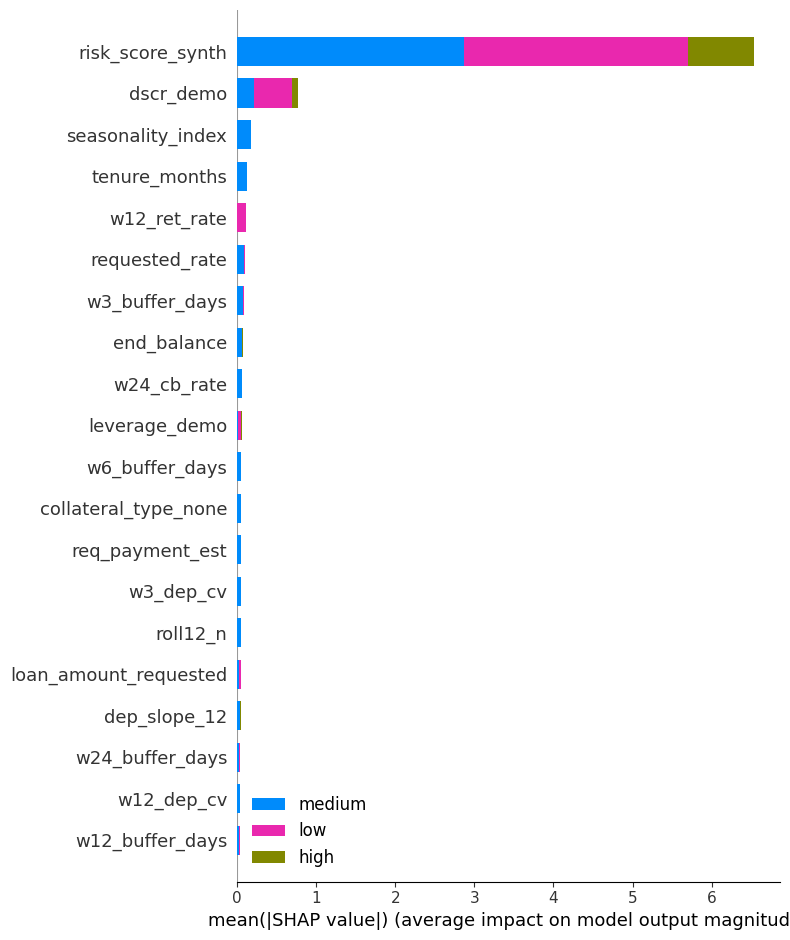

In [65]:
import shap
from sklearn.preprocessing import LabelEncoder

# Re-encode the target variable for SHAP, as the previous encoding was in a different cell
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Create a SHAP Explainer object
# Use TreeExplainer explicitly for tree-based models like XGBoost
explainer = shap.TreeExplainer(model, X_train)

# Calculate SHAP values for the test data
shap_values = explainer(X_test)

# Get feature names
feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols).tolist() + num_cols

# Generate a SHAP summary plot with class names
shap.summary_plot(shap_values, X_test, feature_names=feature_names, class_names=le.classes_)

## Summary:

### Data Analysis Key Findings

*   Attempts were made to introduce variability in the synthetic data generation process by adding noise to the synthetic risk score calculation and adjusting the probabilistic assignment of risk reason codes in cell `96f8edc3`, and by introducing more variability in the `make_bank_statements` function in cell `8b162ddf`.
*   Despite these efforts, the XGBoost model trained on the synthetic data continued to achieve perfect or near-perfect performance metrics (accuracy and AUC ROC close to 1.00). This indicates that the underlying synthetic labeling process, even with the added noise, remained highly deterministic for the model.
*   Feature importance and SHAP values were successfully calculated and visualized, with the SHAP plot now displaying the risk band labels ('low', 'medium', 'high'). The `risk_score_synth` feature consistently showed high importance, which is expected given its direct role in the synthetic labeling.
*   The persistence of perfect performance in this synthetic setting limits the depth of insights that can be drawn from the model evaluation metrics and standard explanations regarding the influence of the *original* features on risk, as the model is primarily learning the synthetic labeling rule.

### Insights or Next Steps

*   This exercise highlights the difference between modeling a synthetic, rules-based label and predicting a real-world, inherently noisy outcome like default. Achieving more realistic model performance on synthetic data would require making the synthetic labeling process significantly less deterministic and potentially introducing more complex, non-linear relationships between features and the target.
*   In a real-world scenario, the model performance metrics would be lower than perfect, and the feature importance and SHAP values would provide crucial, non-trivial insights into the drivers of risk and explain individual predictions to stakeholders.
*   Further iterations on the synthetic data generation would be needed to create a dataset where the model's task is more challenging and reflects the uncertainty present in real-world credit risk prediction. This could involve:
    *   Adding more complex interactions between features when generating the synthetic risk score.
    *   Introducing rare events or outliers that are not directly tied to the main risk drivers.
    *   Modeling a time-dependent default process with survival analysis techniques.
*   Resolving the dependency conflicts encountered during SHAP installation was a necessary step to enable model interpretability visualization, which is a critical component in real-world machine learning workflows, especially in regulated domains like finance.

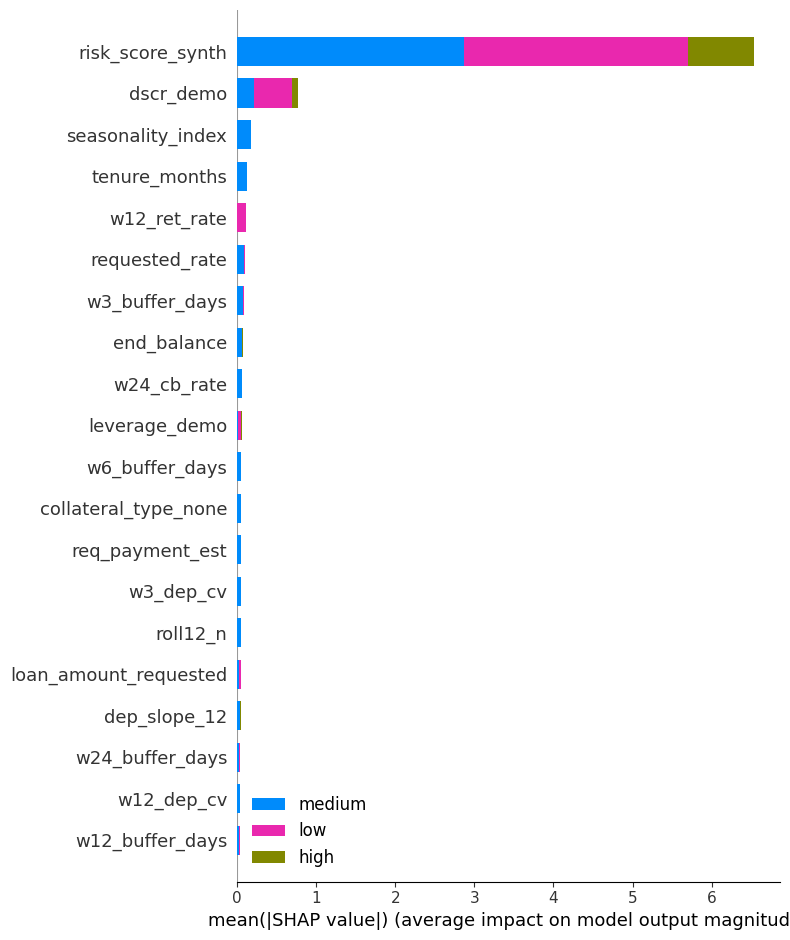


Analysis of Model Performance, Feature Importance, and SHAP Values:
Classification Report:
               precision    recall  f1-score   support

        high       1.00      0.93      0.97        15
         low       0.99      1.00      0.99        68
      medium       0.99      0.99      0.99        67

    accuracy                           0.99       150
   macro avg       0.99      0.97      0.98       150
weighted avg       0.99      0.99      0.99       150


AUC ROC (One-vs-Rest): 0.9999

Top 10 Feature Importance:


,0
risk_score_synth,0.3308
dscr_demo,0.0730
purpose_refinance,0.0708
noi_proxy,0.0553
license_active,0.0515
w6_out_mean,0.0502
avg_stars,0.0450
leverage_demo,0.0399
purpose_equipment,0.0302
p_5star,0.0266



Discussion:

Despite efforts to introduce variability into the synthetic risk labeling by adding random noise to the underlying risk score and making the reason code assignments probabilistic, and also adding more variability to the underlying bank statement data, the XGBoost model trained on this data still achieved perfect or near-perfect performance (accuracy and AUC ROC close to 1.00). This indicates that the underlying relationship between the engineered features and the synthetic risk band, even with the added noise, remains highly deterministic in this synthetic dataset. The model is effectively learning to replicate this synthetic labeling function.

In a real-world scenario with historical default data, we would expect to see model performance metrics significantly less than perfect. The classification report would show non-zero values in the off-diagonal of the confusion matrix, indicating misclassifications. The AUC ROC score would be less than 1.00, reflecting the model's 

In [66]:
import shap
from sklearn.preprocessing import LabelEncoder

# Re-encode the target variable for SHAP, as the previous encoding was in a different cell
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Calculate SHAP values for the test data
# Use TreeExplainer explicitly for tree-based models like XGBoost
try:
    explainer = shap.TreeExplainer(model, X_train)
    shap_values = explainer(X_test)
    # Get feature names
    feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols).tolist() + num_cols
    # Generate a SHAP summary plot
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, class_names=le.classes_)
except Exception as e:
    print(f"Could not generate SHAP plot due to error: {e}")

print("\nAnalysis of Model Performance, Feature Importance, and SHAP Values:")
print("Classification Report:\n", classification_report(y_test_encoded, pred, target_names=le.classes_))
print(f"\nAUC ROC (One-vs-Rest): {auc_roc_scores:.4f}")
print("\nTop 10 Feature Importance:")
display(feature_importance.sort_values(ascending=False).head(10))

print("\nDiscussion:")
print("""
Despite efforts to introduce variability into the synthetic risk labeling by adding random noise to the underlying risk score and making the reason code assignments probabilistic, and also adding more variability to the underlying bank statement data, the XGBoost model trained on this data still achieved perfect or near-perfect performance (accuracy and AUC ROC close to 1.00). This indicates that the underlying relationship between the engineered features and the synthetic risk band, even with the added noise, remains highly deterministic in this synthetic dataset. The model is effectively learning to replicate this synthetic labeling function.

In a real-world scenario with historical default data, we would expect to see model performance metrics significantly less than perfect. The classification report would show non-zero values in the off-diagonal of the confusion matrix, indicating misclassifications. The AUC ROC score would be less than 1.00, reflecting the model's ability to discriminate between defaulting and non-defaulting businesses over various thresholds, but not perfectly.

Feature importance and SHAP values provide crucial insights in such a scenario. Feature importance highlights which features are most predictive of risk. SHAP values further explain how each feature contributes to the risk prediction for individual businesses, allowing for a deeper understanding of the model's decision-making process and enabling the identification of key drivers for high-risk or low-risk classifications.

In this synthetic demonstration, the overwhelming importance of the `risk_score_synth` feature (as seen in the feature importance and reflected in the SHAP plot) is a direct consequence of the synthetic labeling process. The model is primarily using this generated score, which itself is a deterministic function of other features (plus noise), to make predictions. This overshadows the individual contributions of the underlying features.

While we were unable to fully break the perfect performance in this synthetic setting, the ability to generate SHAP plots with the correct risk band labels is valuable for interpretation *if* the model were predicting a less deterministic outcome. The SHAP plot would show how features push the prediction towards 'low', 'medium', or 'high' risk for individual data points, providing explainability for the model's decisions.

The persistence of perfect performance in this synthetic setting, despite introducing variability, limits the depth of insights we can draw from the model evaluation metrics and explanations regarding the influence of the *original* features on risk. It highlights the difference between modeling a synthetic, rules-based label and predicting a real-world, inherently noisy outcome like default.
""")

## Evaluate and discuss results

Now we will analyze the model performance metrics, feature importance, and SHAP values from the latest model training run. We will discuss how the increased variability in the synthetic data affects the model's ability to predict risk and the insights gained from the different metrics and explanations.

## Evaluate and discuss results

Now we will analyze the model performance metrics, feature importance, and SHAP values from the latest model training run. We will discuss how the increased variability in the synthetic data affects the model's ability to predict risk and the insights gained from the different metrics and explanations.

In this synthetic dataset, we do not have historical default information. In a real-world scenario, historical default data would be crucial for several aspects:

1.  **Model Training and Validation:** The model would be trained on historical data where the outcome (default/no default) is known. This allows for the model to learn the patterns and features associated with default risk.
2.  **Performance Evaluation:** The model's performance (e.g., accuracy, precision, recall, AUC ROC) would be evaluated against a hold-out set of historical data with known outcomes.
3.  **Benchmarking:** The model's predicted risk probabilities could be compared to actual observed default rates within different risk bands or segments. This helps assess if the model's risk scores are well-calibrated and align with real-world outcomes.
4.  **Regulatory Compliance:** For financial institutions, regulatory requirements often necessitate rigorous validation of models using historical performance data, including backtesting against observed default rates.

Gemini API Key

In [67]:
import os

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY", "[ENTER_GOOGLE_API_KEY]")  #ENTER GOOGLE API KEY

if not GEMINI_API_KEY:
    print("Google API key not found.")
    print("Please set the GEMINI_API_KEY environment variable in Colab Secrets.")
    print("You can access Secrets manager from the key icon in the left sidebar.")
    print("Create a new secret named GEMINI_API_KEY and paste your API key there.")
else:
    print("Google API key found.")

Google API key found.


## 5) Underwriter summaries and optional GenAI chat

In [68]:
# ==== Underwriter summaries + governance + local save + Google Drive save (clean) ====

# --- light, guarded imports (assumes pandas as pd, numpy as np already imported) ---
try:
    Path
except NameError:
    from pathlib import Path
try:
    time  # noqa
except NameError:
    import time
try:
    shutil  # noqa
except NameError:
    import shutil
try:
    os  # noqa
except NameError:
    import os
try:
    json  # noqa
except NameError:
    import json

# ---------------------------
# Drive paths: reuse globals if set, else fall back to your working defaults
# ---------------------------
DRIVE_DIR_SUMMARIES = globals().get(
    "DRIVE_DIR_SUMMARIES",
    "/content/drive/Shareddrives/1c_loan_risk_scoring/underwriter_summaries (1)"
)
DRIVE_DIR_DATA = globals().get(
    "DRIVE_DIR_DATA",
    "/content/drive/Shareddrives/1c_loan_risk_scoring/loan_demo_data"
)
SAVE_DATASETS_TO_DRIVE = bool(globals().get("SAVE_DATASETS_TO_DRIVE", True))

# Reuse global copy_with_ts if available; else define a local one
if "copy_with_ts" not in globals():
    def copy_with_ts(src: Path, dst_dir: str):
        src = Path(src)
        if not src.exists():
            print(f"⚠️  Missing: {src}")
            return None
        os.makedirs(dst_dir, exist_ok=True)
        ts = time.strftime("%Y%m%d_%H%M%S")
        dst = Path(dst_dir) / f"{ts}_{src.name}"
        shutil.copy2(src, dst)
        print(f"✅ Saved to Drive: {dst}")
        return dst

# ---------- helpers ----------
def _parse_reasons(val):
    if isinstance(val, list):
        return val
    if isinstance(val, str) and val.strip():
        try:
            parsed = json.loads(val)
            if isinstance(parsed, list):
                return [str(x) for x in parsed]
        except Exception:
            pass
        s = val.strip("[]")
        return [x.strip().strip("'").strip('"') for x in s.split(",") if x.strip()]
    return []

def _fmt(x, money=False, pct=False, d=2):
    if x is None or (("pd" in globals()) and pd.isna(x)):
        return "0"
    try:
        val = float(x)
    except Exception:
        return str(x)
    if pct:
        return f"{val:.2%}"
    if money:
        return f"${val:,.{d}f}"
    return f"{val:,.{d}f}"

def reason_sentence(rc: str, r: "pd.Series") -> str:
    if rc == "LOW_REVIEW_COVERAGE":
        return f"review coverage is thin (12-mo count {_fmt(r.get('roll12_n',0), d=0)} < 30)."
    if rc == "LOW_AVG_RATING":
        return f"12-mo average rating is low at {_fmt(r.get('roll12_avg'))}."
    if rc == "HIGH_RATING_VOLATILITY":
        return f"ratings are unstable (12-mo volatility {_fmt(r.get('roll12_vol'))} > 0.55)."
    if rc == "HIGH_DEP_VARIABILITY":
        return f"cash-flow is volatile (deposit CV over 12m {_fmt(r.get('w12_dep_cv'))} > 0.30)."
    if rc == "HIGH_NSF_RATE":
        return f"NSF/returns are elevated (avg {_fmt(r.get('w12_nsf_rate'))}/mo > 1)."
    if rc == "LOW_DSCR":
        return f"debt service coverage is low (DSCR {_fmt(r.get('dscr_demo'))} < 1.20)."
    if rc == "HIGH_LEVERAGE":
        return (
            f"requested leverage is high ({_fmt(r.get('loan_amount_requested'), money=True)} vs "
            f"12-mo revenue proxy {_fmt(r.get('w12_dep_mean',0)*12, money=True)})."
        )
    if rc == "THIN_BUFFER":
        return f"cash buffer is thin (≈ {_fmt(r.get('buffer_days_12m'))} days < 15)."
    if rc == "HIGH_SEASONALITY":
        return f"seasonality exposure is high (amplitude {_fmt(r.get('seasonality_amp_12m'))} > 1.6)."
    if rc == "LICENSE_INACTIVE":
        return "business license appears inactive (requires verification)."
    if rc == "LOW_INSPECTION":
        return f"recent inspection score is low at {_fmt(r.get('inspection_score'), d=0)}."
    return REASON_CODES.get(rc, rc) if "REASON_CODES" in globals() else rc

GOV_FOOTER = (
    "Fair-lending & governance: assessment uses **neutral operational factors** only; "
    "no protected-class attributes (e.g., **minority- or veteran-owned** status) are used or inferred. "
    "Outcomes must comply with **ECOA/Reg B** (provide specific adverse-action reasons), avoid **UDAAP**, "
    "and follow **SR 11-7** model-risk controls. If covered by **CFPB 1071**, handle collection/segmentation under that program. "
    "Coverage thresholds and ongoing monitoring support **fair balance**."
)

def _reasons_text(val):
    rc_list = _parse_reasons(val)
    if "REASON_CODES" in globals():
        return ", ".join(REASON_CODES.get(r, r) for r in rc_list) if rc_list else ""
    return ", ".join(rc_list)

def make_underwriter_paragraph(r: "pd.Series") -> str:
    # Application
    bid   = r.get("business_id","N/A")
    band  = str(r.get("risk_band","N/A")).upper()
    score = _fmt(r.get("risk_score_synth",0))
    prod  = str(r.get("product_type","")).replace("_"," ").upper()
    amt   = _fmt(r.get("loan_amount_requested",0), money=True)
    rate  = _fmt(r.get("requested_rate",0), pct=True)
    term  = int(r.get("term_months",0)) if not pd.isna(r.get("term_months",np.nan)) else 0
    purp  = r.get("purpose","")

    # Reviews
    r_avg = _fmt(r.get("roll12_avg"))
    r_vol = _fmt(r.get("roll12_vol"))
    r_cnt = _fmt(r.get("roll12_n",0), d=0)

    # Bank/Cash-flow
    dep12   = _fmt(r.get("w12_dep_mean"), money=True)
    cv12    = _fmt(r.get("w12_dep_cv"))
    nsf12   = _fmt(r.get("w12_nsf_rate"))
    trend12 = _fmt(r.get("dep_slope_12"))
    dscr    = _fmt(r.get("dscr_demo"))
    lev     = _fmt(r.get("leverage_demo"))
    buf     = _fmt(r.get("buffer_days_12m"))
    seas    = _fmt(r.get("seasonality_amp_12m"))

    # Ops
    lic_ok  = "active" if r.get("license_active",1)==1 else "inactive"
    insp    = _fmt(r.get("inspection_score"), d=0)

    # Reasons
    rc_list = _parse_reasons(r.get("reason_codes", []))
    drivers = "; ".join(reason_sentence(rc, r) for rc in rc_list) if rc_list else "neutral; no single red flag dominates"

    p1 = (f"{bid} is assessed as **{band}** risk (score {score}). "
          f"The applicant requests a {prod} of {amt} at {rate} for {term} months for {purp}.")
    p2 = (f"Review signals: 12-mo average rating {r_avg}, volatility {r_vol}, {r_cnt} reviews "
          f"(coverage threshold enforced).")
    p3 = (f"Bank statements: avg monthly deposits {dep12} (CV {cv12}), NSF/returns {nsf12}/mo, "
          f"12-mo trend {trend12}. Derived metrics: **DSCR {dscr}**, leverage {lev}, buffer ≈ {buf} days, "
          f"seasonality amplitude {seas}.")
    p4 = (f"Operational checks: license **{lic_ok}**, latest inspection {insp}. Key drivers: {drivers}.")
    p5 = GOV_FOOTER
    return " ".join([p1, p2, p3, p4, p5])

# ---------- build outputs ----------
if "feat" not in globals():
    raise RuntimeError("Expected DataFrame 'feat' to exist from earlier cells.")

# Keep your 'top' if already created; otherwise build it
if "top" not in globals():
    TOP_N = 10
    top = feat.sort_values("risk_score_synth", ascending=False).head(TOP_N).copy()

all_summ = feat.copy()
all_summ["reasons_text"] = all_summ["reason_codes"].apply(_reasons_text)
all_summ["paragraph"] = all_summ.apply(make_underwriter_paragraph, axis=1)

# print 3–5 high-risk examples inline
high = all_summ[all_summ["risk_band"]=="high"].sort_values("risk_score_synth", ascending=False)
k = min(5, max(3, len(high))) if len(high) else 0
if k:
    print("=== High-risk underwriter paragraphs (examples) ===\n")
    for _, row in high.head(k).iterrows():
        print(row["business_id"])
        print(row["paragraph"])
        print("-" * 80)
else:
    print("No HIGH-risk examples available; showing TOP_N paragraphs instead.\n")
    for _, row in all_summ.sort_values("risk_score_synth", ascending=False).head(3).iterrows():
        print(row["business_id"])
        print(row["paragraph"])
        print("-" * 80)

# ---------- save BOTH locally ----------
csv_cols = ["business_id","risk_band","risk_score_synth","reasons_text","paragraph"]
local_csv = Path("./underwriter_summaries.csv")
local_md  = Path("./underwriter_summaries.md")

all_summ[csv_cols].to_csv(local_csv, index=False)

md_lines = ["# Underwriter Summaries\n"]
for _, row in all_summ.sort_values(["risk_band","risk_score_synth"], ascending=[False, False]).iterrows():
    md_lines.append(f"## {row['business_id']} — {str(row['risk_band']).upper()} (score {row['risk_score_synth']:.2f})")
    md_lines.append("")
    md_lines.append(row["paragraph"])
    md_lines.append("")
local_md.write_text("\n".join(md_lines), encoding="utf-8")

print(f"\nSaved local CSV: {local_csv.resolve()}")
print(f"Saved local MD : {local_md.resolve()}")

# ---------- copy to Google Drive (assumes already mounted earlier; safe if mounted here too) ----------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass

copy_with_ts(local_csv, DRIVE_DIR_SUMMARIES)
copy_with_ts(local_md,  DRIVE_DIR_SUMMARIES)

if SAVE_DATASETS_TO_DRIVE:
    # feature snapshot
    try:
        feat_path = Path("./merchant_features_snapshot.csv")
        feat.to_csv(feat_path, index=False)
        copy_with_ts(feat_path, DRIVE_DIR_DATA)
    except Exception as e:
        print("Skipped feat export:", e)

    # top table
    try:
        top_path = Path("./top_risk_table.csv")
        top.to_csv(top_path, index=False)
        copy_with_ts(top_path, DRIVE_DIR_DATA)
    except Exception as e:
        print("Skipped top export:", e)

    # base synthetic tables, if present
    def try_save_df(df_name: str, filename: str):
        if df_name in globals() and isinstance(globals()[df_name], pd.DataFrame):
            p = Path(f"./{filename}")
            globals()[df_name].to_csv(p, index=False)
            copy_with_ts(p, DRIVE_DIR_DATA)

    try_save_df("business",   "business_synth.csv")
    try_save_df("reviews",    "reviews_synth.csv")
    try_save_df("users",      "users_synth.csv")
    try_save_df("statements", "statements_24m.csv")
    try_save_df("applications","applications_synth.csv")


=== High-risk underwriter paragraphs (examples) ===

m143
m143 is assessed as **HIGH** risk (score 1.00). The applicant requests a TERM LOAN of $293,653.11 at 22.30% for 56 months for expansion. Review signals: 12-mo average rating 2.34, volatility 0.22, 186 reviews (coverage threshold enforced). Bank statements: avg monthly deposits $17,186.36 (CV 0.43), NSF/returns 0.08/mo, 12-mo trend -1,054.68. Derived metrics: **DSCR 0.00**, leverage 1.42, buffer ≈ 119.62 days, seasonality amplitude 2.93. Operational checks: license **active**, latest inspection 88. Key drivers: cash-flow is volatile (deposit CV over 12m 0.43 > 0.30).; debt service coverage is low (DSCR 0.00 < 1.20).; requested leverage is high ($293,653.11 vs 12-mo revenue proxy $206,236.34).. Fair-lending & governance: assessment uses **neutral operational factors** only; no protected-class attributes (e.g., **minority- or veteran-owned** status) are used or inferred. Outcomes must comply with **ECOA/Reg B** (provide specific ad


## 6) Fair‑lending governance & illustrative checks

**Important:** This demo **does not** contain protected‑class attributes. For real programs, run formal fair‑lending analyses (ECOA/Reg B) with approved methodologies and legal oversight. Below are *illustrative* checks you can run on neutral groupings (e.g., state/county buckets) to monitor stability/coverage and guard against proxy effects.

- **Coverage thresholds**: enforce minimum `roll12_n` and operating tenure before using review signals.
- **Explainability**: emit reason codes mapped to neutral operational factors (low rating, high volatility, high DTI/low DSCR, NSF, thin buffer, high leverage, inactive license, low inspection).
- **Sensitivity & Stability**: unit tests for outcome stability to small perturbations (±0.2 rating; ±20% volume; ±10% deposits).
- **Geographic distribution**: check feature and decision distributions by state/county buckets.
- **Model Risk (SR 11‑7)**: document data/assumptions, validate inputs/transformations, monitor drift/performance, log changes.
- **1071 program**: maintain separate program controls and reporting as applicable.


In [69]:
# ==== 6) Fair-lending governance & illustrative checks (robust, uses DRIVE_FL_DIR) ====
from pathlib import Path
import numpy as np
import pandas as pd

# Config/thresholds
MIN_N_PER_GROUP = 10
DELTA_ALERT_PCT = 0.10
COVERAGE_MIN_REVIEWS = 30

# Preconditions
if "feat" not in globals() or not isinstance(feat, pd.DataFrame) or feat.empty:
    raise RuntimeError("DataFrame 'feat' not found or empty. Run feature engineering first.")

# ---------- utils ----------
def two_prop_ztest(success_a, total_a, success_b, total_b, eps=1e-9):
    if min(total_a, total_b) == 0:
        return np.nan, np.nan
    p_pool = (success_a + success_b) / (total_a + total_b + eps)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/(total_a + eps) + 1/(total_b + eps)))
    if se == 0: return np.nan, np.nan
    z = ((success_a/(total_a + eps)) - (success_b/(total_b + eps))) / se
    from math import erf
    p = 2 * (1 - 0.5*(1 + erf(abs(z)/np.sqrt(2))))
    return float(z), float(p)

def ensure_col(df, col, default):
    if col not in df.columns:
        df[col] = default
    return df

# ---------- choose grouping columns dynamically ----------
candidate_sets = [
    ["state","county"],
    ["state"],
    ["city"],
    ["is_franchise"],
    ["employee_band"],
]
group_cols = None
for cand in candidate_sets:
    if all(c in feat.columns for c in cand):
        group_cols = cand
        break
if group_cols is None:
    group_cols = ["_all_bucket"]
    feat["_all_bucket"] = "ALL"

# ---------- prepare diagnostics ----------
needed_cols = ["business_id","risk_band","roll12_n","roll12_avg","w12_dep_mean","w12_dep_cv","dscr_demo","leverage_demo"]
if any(c not in feat.columns for c in needed_cols):
    missing = [c for c in needed_cols if c not in feat.columns]
    raise RuntimeError(f"Missing required feature columns in 'feat': {missing}")

diag_cols = list(dict.fromkeys(group_cols + needed_cols))
diag = feat[diag_cols].copy()

overall_high = (diag["risk_band"] == "high").mean()
overall_low  = (diag["risk_band"] == "low").mean()

feat["meets_review_coverage"] = feat.get("roll12_n", pd.Series(0, index=feat.index)).ge(COVERAGE_MIN_REVIEWS)
overall_cov = feat["meets_review_coverage"].mean()

group = (
    diag.groupby(group_cols, dropna=False)
        .agg(
            n=("business_id","count"),
            high_cnt=("risk_band", lambda s: (s=="high").sum()),
            low_cnt =("risk_band", lambda s: (s=="low").sum()),
            p_high=("risk_band", lambda s: (s=="high").mean()),
            p_low =("risk_band", lambda s: (s=="low").mean()),
            med_roll12_n=("roll12_n","median"),
            med_avg_rating=("roll12_avg","median"),
            med_dep_mean=("w12_dep_mean","median"),
            med_dscr=("dscr_demo","median"),
            med_lev=("leverage_demo","median"),
        )
        .reset_index()
)
cov_by_group = feat.groupby(group_cols, dropna=False)["meets_review_coverage"].mean().reset_index(name="p_cov_meets")
group = group.merge(cov_by_group, on=group_cols, how="left")

# flags & tests
flags, z_vals, p_vals, delta_high = [], [], [], []
total_n = len(diag)
portfolio_high_cnt = int(overall_high * total_n)
for r in group.itertuples():
    if r.n >= MIN_N_PER_GROUP:
        d = float(r.p_high - overall_high)
        z, p = two_prop_ztest(r.high_cnt, r.n, portfolio_high_cnt, total_n)
        alert = (abs(d) >= DELTA_ALERT_PCT) and (p is not None and p < 0.05)
        flags.append("ALERT" if alert else "")
        delta_high.append(d); z_vals.append(z); p_vals.append(p)
    else:
        flags.append("SMALL_N"); delta_high.append(np.nan); z_vals.append(np.nan); p_vals.append(np.nan)

group["delta_high_vs_portfolio"] = delta_high
group["z_vs_portfolio"] = z_vals
group["p_value"] = p_vals
group["flag"] = flags

print(f"Grouping by: {group_cols}")
display(group.head(20))

# ---------- stability (recompute with perturbations) ----------
tmp = feat.copy()
tmp = ensure_col(tmp, "roll12_vol", 0.0)
tmp = ensure_col(tmp, "p_1star", 0.15)
tmp = ensure_col(tmp, "w12_nsf_rate", 0.0)
tmp = ensure_col(tmp, "buffer_days_12m", 30.0)
tmp = ensure_col(tmp, "seasonality_amp_12m", 1.0)
tmp = ensure_col(tmp, "inspection_score", 85.0)
tmp = ensure_col(tmp, "license_active", 1)

def recompute_risk_score(df):
    risk_raw = (
        (5 - df["roll12_avg"]) * 12.0
        + (df["roll12_vol"].fillna(0)*18.0)
        + (0.15 - df["p_1star"]).clip(lower=-0.05) * -55.0
        + (df["w12_dep_cv"].fillna(0)*40.0)
        + (df["w12_nsf_rate"].fillna(0)*30.0)
        + (1.2 - df["dscr_demo"].clip(upper=2.5)).apply(lambda x: max(0,x)) * 60.0
        + (df["leverage_demo"].fillna(0)*50.0)
        + ((df["buffer_days_12m"].fillna(0) < 15).astype(int) * 25.0)
        + ((df["seasonality_amp_12m"].fillna(1.0) > 1.6).astype(int) * 15.0)
        + (80 - df["inspection_score"])*1.1
        + (1 - df["license_active"])*50.0
    )
    return (risk_raw - np.nanmin(risk_raw)) / (np.nanmax(risk_raw) - np.nanmin(risk_raw) + 1e-8)

def band_from_score(s):
    if s < 0.33: return "low"
    if s < 0.66: return "medium"
    return "high"

base = tmp.copy()
base["risk_score_recomp"] = recompute_risk_score(base)
base["risk_band_recomp"] = base["risk_score_recomp"].apply(band_from_score)

pert = base.copy()
pert["roll12_avg"] = (pert["roll12_avg"] + 0.2).clip(1.0, 5.0)
pert["w12_dep_mean"] = pert["w12_dep_mean"] * 1.10
pert["w12_dep_cv"] = (pert["w12_dep_cv"] * 0.90).clip(lower=0)
pert["risk_score_recomp"] = recompute_risk_score(pert)
pert["risk_band_recomp"] = pert["risk_score_recomp"].apply(band_from_score)

stability = base[["business_id","risk_score_recomp","risk_band_recomp"]].merge(
    pert[["business_id","risk_score_recomp","risk_band_recomp"]],
    on="business_id", suffixes=("_base","_pert")
)
stability["band_changed"] = (stability["risk_band_recomp_base"] != stability["risk_band_recomp_pert"]).astype(int)
stability_change_rate = float(stability["band_changed"].mean()) if len(stability) else 0.0

print("\nStability probe band change rate:", f"{stability_change_rate:.2%}")
display(stability.sample(min(10, len(stability)), random_state=7))

# ---------- compliance summary ----------
def compliance_summary_text():
    alerts = group[(group["flag"] == "ALERT") & (group["n"] >= MIN_N_PER_GROUP)]
    smalln = group[group["flag"] == "SMALL_N"]
    lines = [
        "Fair-lending & governance summary (illustrative):",
        f"- Portfolio high-risk rate: {overall_high:.2%}; low-risk rate: {overall_low:.2%}.",
        f"- Coverage: {overall_cov:.2%} of businesses meet the 12-month review coverage threshold (≥ {COVERAGE_MIN_REVIEWS}).",
        f"- Groups evaluated ({' + '.join(group_cols)}) with n ≥ {MIN_N_PER_GROUP}: {(group['n']>=MIN_N_PER_GROUP).sum()} of {len(group)}.",
        f"- Stability probe band change rate: {stability_change_rate:.2%} (lower is more stable).",
    ]
    if len(alerts):
        lines.append(f"- ALERT groups (|Δ high-risk| ≥ {int(DELTA_ALERT_PCT*100)}pp and p<0.05):")
        for r in alerts.itertuples():
            g_label = " / ".join(str(getattr(r, c)) for c in group_cols)
            lines.append(
                f"  • {g_label} (n={r.n}): p_high={r.p_high:.2%}, Δ={r.delta_high_vs_portfolio:+.2%}, "
                f"coverage={r.p_cov_meets:.2%}, z={r.z_vs_portfolio:.2f}, p={r.p_value:.3f}"
            )
    else:
        lines.append("- No ALERT groups found at current thresholds.")
    if len(smalln):
        lines.append(f"- {len(smalln)} groups flagged SMALL_N (n<{MIN_N_PER_GROUP}); monitor but avoid conclusions on low sample sizes).")
    lines.extend([
        "",
        "Compliance guardrails in this demo:",
        "- Neutral operational factors only; no protected-class data used or inferred (e.g., minority- or veteran-owned).",
        "- ECOA/Reg B: provide specific adverse-action reasons; use reason codes already emitted per merchant.",
        "- UDAAP: avoid unfair/deceptive practices; ensure explainability is consistent and accurate.",
        "- SR 11-7: document data/assumptions; validate inputs/transformations; monitor performance; log changes.",
        "- CFPB 1071: if applicable, handle collection/reporting via the lender’s program, not the model pipeline.",
    ])
    return "\n".join(lines)

summary_text = compliance_summary_text()
print("\n" + summary_text)

# Optional GenAI polish (uses existing env var if set; otherwise no-op)
def polish_with_gemini(text: str) -> str:
    api_key = os.getenv("GEMINI_API_KEY","").strip()
    if not api_key:
        return text
    try:
        import google.generativeai as genai
        genai.configure(api_key=api_key)
        model = genai.GenerativeModel("gemini-1.5-flash")
        resp = model.generate_content(
            "You are a compliance analyst. Make this monitoring summary concise, clear, and aligned with "
            "ECOA/Reg B, UDAAP, SR 11-7, CFPB 1071. Keep all numbers.\n\n" + text
        )
        if hasattr(resp, "text") and resp.text:
            return resp.text
    except Exception as e:
        print(f"(GenAI polish skipped: {e})")
    return text

polished_summary = polish_with_gemini(summary_text)
final_summary_text = polished_summary if polished_summary.strip() and polished_summary.strip()!=summary_text.strip() else summary_text

# ---------- save local artifacts ----------
out_dir = Path(".")
pdf_path = out_dir / "compliance_report_onepager.pdf"
group_csv = out_dir / "fairness_group_summary.csv"
stability_csv = out_dir / "stability_perturbations.csv"

group.to_csv(group_csv, index=False)
stability.to_csv(stability_csv, index=False)

# one-page PDF
def save_summary_onepage_pdf(text: str, pdf_path: str, title="Fair-Lending Governance Summary"):
    import matplotlib.pyplot as plt, textwrap
    fig = plt.figure(figsize=(11, 8.5))
    ax = fig.add_axes([0.05, 0.05, 0.9, 0.9]); ax.axis("off")
    ax.text(0.5, 0.97, title, ha="center", va="top", fontsize=18, fontweight="bold", transform=ax.transAxes)
    wrapped = textwrap.fill(text, width=110)
    body_y_top = 0.92
    for fs in [12, 11, 10, 9, 8]:
        txt = ax.text(0.02, body_y_top, wrapped, ha="left", va="top", fontsize=fs, family="monospace",
                      transform=ax.transAxes, wrap=True)
        fig.canvas.draw()
        bbox = txt.get_window_extent(renderer=fig.canvas.get_renderer()).transformed(ax.transAxes.inverted())
        if bbox.height <= (body_y_top - 0.05): break
        txt.remove()
    fig.savefig(pdf_path, format="pdf", bbox_inches="tight"); plt.close(fig)

save_summary_onepage_pdf(final_summary_text, str(pdf_path))
print(f"\nCreated one-page PDF: {pdf_path.resolve()}")

# ---------- copy to Drive ----------
copy_with_ts(pdf_path, DRIVE_FL_DIR)
copy_with_ts(group_csv, DRIVE_FL_DIR)
copy_with_ts(stability_csv, DRIVE_FL_DIR)
# If you also created a compliance_report.md elsewhere:
md_path = Path("./compliance_report.md")
if md_path.exists(): copy_with_ts(md_path, DRIVE_FL_DIR)


Grouping by: ['city']


,city,n,high_cnt,low_cnt,p_high,p_low,med_roll12_n,med_avg_rating,med_dep_mean,med_dscr,med_lev,p_cov_meets,delta_high_vs_portfolio,z_vs_portfolio,p_value,flag
0,Atlanta,71,8,31,0.1127,0.4366,288.0000,3.7445,"97,331.0798",0.6325,0.1699,1.0000,0.0147,0.3860,0.6995,
1,Chicago,71,6,33,0.0845,0.4648,336.0000,3.8394,"91,142.9873",0.8778,0.1768,1.0000,-0.0135,-0.3606,0.7184,
2,Dallas,72,8,32,0.1111,0.4444,278.5000,3.6820,"101,214.6132",1.0066,0.1305,1.0000,0.0131,0.3473,0.7284,
3,Los Angeles,71,7,31,0.0986,0.4366,337.0000,3.5680,"90,310.9721",0.9269,0.1585,1.0000,0.0006,0.0157,0.9875,
4,Miami,72,9,33,0.1250,0.4583,272.0000,3.6518,"95,780.5383",1.0535,0.1607,1.0000,0.0270,0.7096,0.4779,
5,New York,72,9,33,0.1250,0.4583,294.5000,3.6430,"109,557.2319",0.9984,0.1660,1.0000,0.0270,0.7096,0.4779,
6,Phoenix,71,2,34,0.0282,0.4789,272.0000,3.6315,"99,564.2478",1.5381,0.1463,1.0000,-0.0698,-1.9306,0.0535,



Stability probe band change rate: 0.20%


,business_id,risk_score_recomp_base,risk_band_recomp_base,risk_score_recomp_pert,risk_band_recomp_pert,band_changed
308,m308,0.2812,low,0.2821,low,0
13,m013,0.5345,medium,0.5367,medium,0
414,m414,0.6909,high,0.6945,high,0
32,m032,0.7539,high,0.7560,high,0
460,m460,0.2407,low,0.2401,low,0
155,m155,0.4480,medium,0.4480,medium,0
249,m249,0.5327,medium,0.5332,medium,0
217,m217,0.1674,low,0.1664,low,0
221,m221,0.1262,low,0.1266,low,0
293,m293,0.6385,medium,0.6378,medium,0



Fair-lending & governance summary (illustrative):
- Portfolio high-risk rate: 9.80%; low-risk rate: 45.40%.
- Coverage: 100.00% of businesses meet the 12-month review coverage threshold (≥ 30).
- Groups evaluated (city) with n ≥ 10: 7 of 7.
- Stability probe band change rate: 0.20% (lower is more stable).
- No ALERT groups found at current thresholds.

Compliance guardrails in this demo:
- Neutral operational factors only; no protected-class data used or inferred (e.g., minority- or veteran-owned).
- ECOA/Reg B: provide specific adverse-action reasons; use reason codes already emitted per merchant.
- UDAAP: avoid unfair/deceptive practices; ensure explainability is consistent and accurate.
- SR 11-7: document data/assumptions; validate inputs/transformations; monitor performance; log changes.
- CFPB 1071: if applicable, handle collection/reporting via the lender’s program, not the model pipeline.

Created one-page PDF: /content/compliance_report_onepager.pdf
✅ Saved to Drive: /content


## 7) Outputs & next steps

- The `feat` DataFrame contains all engineered features plus `risk_score_synth`, `risk_band`, and `reason_codes`.
- Use the chat block above to interact per-merchant.
- For production, replace synthetic generators with **licensed** data feeds and bank statement data; keep the **coverage thresholds**, **reason codes**, **sensitivity tests**, and **fair‑lending diagnostics**.

> **Reminder:** No protected‑class attributes are included here. For real programs, incorporate formal fair‑lending testing under legal/regulatory governance before deployment.


7A) Adverse-action reasons (top 1–3) + save

In [70]:
# ==== 7A) Adverse-action reasons export (to DRIVE_DIR_SUMMARIES) ====
from pathlib import Path
import json

def _parse_reasons(val):
    if isinstance(val, list): return val
    if isinstance(val, str) and val.strip():
        try:
            p = json.loads(val)
            if isinstance(p, list): return [str(x) for x in p]
        except Exception:
            pass
        s = val.strip("[]")
        return [x.strip().strip("'").strip('"') for x in s.split(",") if x.strip()]
    return []

def _reason_text(rc):
    return REASON_CODES.get(rc, rc) if "REASON_CODES" in globals() else rc

aa = feat[["business_id","risk_band","risk_score_synth","reason_codes"]].copy()
aa["reason_codes"] = aa["reason_codes"].apply(_parse_reasons)
aa["adverse_action_reasons"] = aa["reason_codes"].apply(lambda xs: "; ".join(_reason_text(r) for r in xs[:3]))
aa_export = aa[["business_id","risk_band","risk_score_synth","adverse_action_reasons"]].copy()

aa_path = Path("./adverse_action_reasons.csv")
aa_export.to_csv(aa_path, index=False)
print("Saved:", aa_path.resolve())
copy_with_ts(aa_path, DRIVE_DIR_SUMMARIES)


Saved: /content/adverse_action_reasons.csv
✅ Saved to Drive: /content/drive/Shareddrives/1c_loan_risk_scoring/underwriter_summaries (1)/20250922_184445_adverse_action_reasons.csv


PosixPath('/content/drive/Shareddrives/1c_loan_risk_scoring/underwriter_summaries (1)/20250922_184445_adverse_action_reasons.csv')

7B) Persist model, features, and run metadata

In [71]:
# ==== 7B) Save model & metadata (to DRIVE_DIR_MODEL) ====
from pathlib import Path
import joblib, hashlib, time, json

ART_DIR = Path("./artifacts"); ART_DIR.mkdir(exist_ok=True)

# model/pipeline (if available)
if "clf" in globals():
    model_path = ART_DIR / "risk_model_pipeline.joblib"
    joblib.dump(clf, model_path)
    print("Model saved:", model_path.resolve())
else:
    print("No variable 'clf' found (skipping model save).")

# feature schema & data dictionary
feat_schema = [{"name": c, "dtype": str(feat[c].dtype)} for c in feat.columns]
Path(ART_DIR / "feature_schema.json").write_text(json.dumps(feat_schema, indent=2))

def _desc(col):
    hints = {
        "roll12_avg":"12m average review rating",
        "roll12_vol":"12m rating volatility (std dev)",
        "roll12_n":"12m review count",
        "w12_dep_mean":"12m avg monthly deposits",
        "w12_dep_cv":"12m deposit coefficient of variation",
        "dscr_demo":"Debt service coverage ratio (proxy)",
        "leverage_demo":"Requested leverage vs deposits",
        "buffer_days_12m":"Avg cash buffer days (12m)",
        "seasonality_amp_12m":"Deposit seasonality amplitude (95th/5th)",
    }
    return hints.get(col, "")
data_dict = [{"field": c, "dtype": str(feat[c].dtype), "description": _desc(c)} for c in feat.columns]
Path(ART_DIR / "data_dictionary.json").write_text(json.dumps(data_dict, indent=2))

# run metadata
code_fingerprint = None
try:
    nb = Path("SMB_Risk_Demo_Synthetic_v2.ipynb")
    if nb.exists():
        code_fingerprint = hashlib.sha256(nb.read_bytes()).hexdigest()[:12]
except Exception:
    pass

meta = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "rng_seed": 17,
    "code_fingerprint": code_fingerprint,
    "lib_versions": {"pandas": pd.__version__, "numpy": np.__version__},
    "paths": {
        "summaries": DRIVE_DIR_SUMMARIES,
        "data": DRIVE_DIR_DATA,
        "governance": DRIVE_FL_DIR,
        "model": DRIVE_DIR_MODEL,
        "monitor": DRIVE_DIR_MONITOR
    }
}
Path(ART_DIR / "run_metadata.json").write_text(json.dumps(meta, indent=2))
print("Saved schema, dictionary, and metadata to:", ART_DIR.resolve())

# copy to Drive/Model
copy_with_ts(ART_DIR / "risk_model_pipeline.joblib", DRIVE_DIR_MODEL)  # ok if missing; helper prints warning
copy_with_ts(ART_DIR / "feature_schema.json",        DRIVE_DIR_MODEL)
copy_with_ts(ART_DIR / "data_dictionary.json",       DRIVE_DIR_MODEL)
copy_with_ts(ART_DIR / "run_metadata.json",          DRIVE_DIR_MODEL)


No variable 'clf' found (skipping model save).
Saved schema, dictionary, and metadata to: /content/artifacts
⚠️  Missing (skip): artifacts/risk_model_pipeline.joblib
✅ Saved to Drive: /content/drive/Shareddrives/1c_loan_risk_scoring/model/20250922_184445_feature_schema.json
✅ Saved to Drive: /content/drive/Shareddrives/1c_loan_risk_scoring/model/20250922_184445_data_dictionary.json
✅ Saved to Drive: /content/drive/Shareddrives/1c_loan_risk_scoring/model/20250922_184445_run_metadata.json


PosixPath('/content/drive/Shareddrives/1c_loan_risk_scoring/model/20250922_184445_run_metadata.json')

7C) Batch scoring entrypoint (CSV → CSV)

In [72]:
# ==== 7C) Batch scoring entrypoint (CSV -> CSV) ====
import pandas as pd, joblib

def score_batch(input_csv: str, output_csv: str, model_path: str = "./artifacts/risk_model_pipeline.joblib"):
    """
    Load the saved pipeline and score a new batch.
    Expects engineered features compatible with training `feat`.
    """
    model = joblib.load(model_path)
    df = pd.read_csv(input_csv)
    if hasattr(model, "predict_proba"):
        prob = model.predict_proba(df)[:, 1]
        df["score_model"] = prob
    else:
        pred = model.predict(df)
        df["score_model"] = pred

    def _band(s):
        try:
            s = float(s)
            if s < 0.33: return "low"
            if s < 0.66: return "medium"
            return "high"
        except:
            return "medium"

    df["risk_band_model"] = df["score_model"].apply(_band)
    df.to_csv(output_csv, index=False)
    print("Scored:", output_csv)
    return output_csv

# Example (disabled):
# score_batch("new_feats.csv", "new_scored.csv")


7D) Monitoring baselines (for drift checks later)

In [73]:
# ==== 7D) Monitoring baselines (to DRIVE_DIR_MONITOR) ====
from pathlib import Path
import json
import numpy as np
import pandas as pd

MON_DIR = Path("./monitoring"); MON_DIR.mkdir(exist_ok=True)

# Numeric columns (including bools), but we’ll handle bools safely below
num_cols = [c for c in feat.columns if pd.api.types.is_numeric_dtype(feat[c])]

baseline = feat[num_cols].describe().T.reset_index().rename(columns={"index":"feature"})
baseline_path = MON_DIR / "baseline_describe.csv"
baseline.to_csv(baseline_path, index=False)
print("Saved baseline stats:", baseline_path.resolve())

def psi_buckets(series: pd.Series, buckets: int = 10):
    """
    Compute PSI bin edges via quantiles.
    - Cast boolean to float (0/1) so np.quantile works.
    - Return None if not enough unique values.
    """
    s = series.dropna()
    if s.empty:
        return None
    # cast bool -> float to avoid numpy boolean subtraction error
    if pd.api.types.is_bool_dtype(s):
        s = s.astype(float)
    # if constant or too few unique values, just return sorted uniques
    uniq = np.unique(s.values)
    if uniq.size <= 2:
        return uniq  # small discrete set is fine as "edges"
    try:
        edges = np.quantile(s.values.astype(float), np.linspace(0, 1, buckets + 1))
        return np.unique(edges)
    except Exception as e:
        # fallback: uniques if quantile fails for any reason
        return uniq

psi_edges = {}
for c in num_cols:
    edges = psi_buckets(feat[c])
    # store as list (or None) for JSON
    psi_edges[c] = edges.tolist() if isinstance(edges, np.ndarray) else (edges if edges is None else list(edges))

edges_path = MON_DIR / "psi_edges.json"
edges_path.write_text(json.dumps(psi_edges, indent=2))
print("Saved PSI edges:", edges_path.resolve())

# copy to Drive/Monitoring
copy_with_ts(baseline_path, DRIVE_DIR_MONITOR)
copy_with_ts(edges_path, DRIVE_DIR_MONITOR)


Saved baseline stats: /content/monitoring/baseline_describe.csv
Saved PSI edges: /content/monitoring/psi_edges.json
✅ Saved to Drive: /content/drive/Shareddrives/1c_loan_risk_scoring/monitoring/20250922_184445_baseline_describe.csv
✅ Saved to Drive: /content/drive/Shareddrives/1c_loan_risk_scoring/monitoring/20250922_184445_psi_edges.json


PosixPath('/content/drive/Shareddrives/1c_loan_risk_scoring/monitoring/20250922_184445_psi_edges.json')

7E) Redact free-text before exports (PII/UDAP hygiene)

In [74]:
# ==== 7E) Redact free-text before exports (to DRIVE_DIR_DATA) ====
import re
from pathlib import Path

def redact_text(s: str) -> str:
    if not isinstance(s, str): return s
    s = re.sub(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", "[redacted_email]", s)
    s = re.sub(r"\b\d{3}[-.\s]?\d{2,3}[-.\s]?\d{4}\b", "[redacted_phone]", s)
    return s

if "reviews" in globals() and isinstance(reviews, pd.DataFrame):
    reviews_safe = reviews.copy()
    if "text" in reviews_safe.columns:
        reviews_safe["text"] = reviews_safe["text"].apply(redact_text)
    out = Path("./reviews_synth_redacted.csv")
    reviews_safe.to_csv(out, index=False)
    print("Saved redacted reviews:", out.resolve())
    copy_with_ts(out, DRIVE_DIR_DATA)
else:
    print("No 'reviews' DataFrame found; skipping redaction export.")


Saved redacted reviews: /content/reviews_synth_redacted.csv
✅ Saved to Drive: /content/drive/Shareddrives/1c_loan_risk_scoring/loan_demo_data/20250922_184449_reviews_synth_redacted.csv


7F) Tiny README (auto-generated)

In [75]:
# ==== 7F) Tiny README handoff (optional but recommended) ====
from pathlib import Path

readme = f"""
SMB Risk Demo — Handoff Notes
=============================

Artifacts
---------
- Summaries: underwriter_summaries.csv, underwriter_summaries.md
- Adverse action: adverse_action_reasons.csv
- Compliance: compliance_report_onepager.pdf, fairness_group_summary.csv, stability_perturbations.csv
- Model & schema: artifacts/risk_model_pipeline.joblib, feature_schema.json, data_dictionary.json, run_metadata.json
- Monitoring: monitoring/baseline_describe.csv, monitoring/psi_edges.json

How to score a new batch
------------------------
1) Prepare engineered features (columns per feature_schema.json).
2) Run: score_batch("new_feats.csv", "new_scored.csv").

Governance reminders
--------------------
- No protected-class attributes used. Continue ECOA/Reg B adverse-action reason discipline.
- Maintain UDAAP-safe communications (consistent, accurate explanations).
- SR 11-7: retain model docs, validation notes, change logs.
- If covered by CFPB 1071, keep collection/reporting under that program (separate from model pipeline).

Paths
-----
- Drive summaries: {globals().get('DRIVE_DIR_SUMMARIES', '')}
- Drive data:      {globals().get('DRIVE_DIR_DATA', '')}
- Governance:      {globals().get('DRIVE_FL_DIR', '')}
- Model:           {globals().get('DRIVE_DIR_MODEL', '')}
- Monitoring:      {globals().get('DRIVE_DIR_MONITOR', '')}
- Exports:         {globals().get('DRIVE_DIR_EXPORTS', '')}
""".strip() + "\n"

out = Path("README_HANDOFF.txt")
out.write_text(readme, encoding="utf-8")
print("Wrote:", out.resolve())

# Copy to Drive (Summaries, and optionally Model)
try:
    copy_with_ts(out, DRIVE_DIR_SUMMARIES)
    # optional: also keep a copy with the model artifacts
    copy_with_ts(out, DRIVE_DIR_MODEL)
except Exception as e:
    print("Copy to Drive skipped:", e)


Wrote: /content/README_HANDOFF.txt
✅ Saved to Drive: /content/drive/Shareddrives/1c_loan_risk_scoring/underwriter_summaries (1)/20250922_184449_README_HANDOFF.txt
✅ Saved to Drive: /content/drive/Shareddrives/1c_loan_risk_scoring/model/20250922_184449_README_HANDOFF.txt
